In [1]:
# STEP 1 — Core Imports
from sentence_transformers import SentenceTransformer
import torch
from sklearn.decomposition import PCA
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Pauli
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_state_city, plot_bloch_multivector

print("✅ All imports working!")


/Users/kritikapandey/kqc_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports working!


In [2]:
!pip install qiskit torch sentence-transformers matplotlib


In [3]:
# Step 1: Quantum-Inspired Memory (3 Qubits)

import numpy as np
from qiskit.quantum_info import Statevector, DensityMatrix

# --- Helper Functions ---
def normalize_complex(vec):
    vec = np.asarray(vec, dtype=np.complex128)
    norm = np.linalg.norm(vec)
    if norm == 0:
        return vec
    return vec / norm

def embed_to_statevector(emb):
    """Convert 8-dimensional embedding to quantum statevector"""
    return Statevector(normalize_complex(emb))

# --- Quantum-Inspired Memory Class ---
class QIMemory:
    def __init__(self, n_qubits=3):
        self.n_qubits = n_qubits
        self.dim = 2 ** n_qubits
        rho_init = np.eye(self.dim, dtype=np.complex128) / self.dim  # start with maximally mixed state
        self.rho = DensityMatrix(rho_init)

    def compress_embeddings(self, embeddings, weights=None):
        if weights is None:
            weights = np.ones(len(embeddings)) / len(embeddings)
        rho = np.zeros((self.dim, self.dim), dtype=np.complex128)
        for w, emb in zip(weights, embeddings):
            sv = embed_to_statevector(emb)
            dm = DensityMatrix(sv)
            rho += w * np.array(dm.data)
        rho /= np.trace(rho)
        self.rho = DensityMatrix(rho)
        return self.rho

    def convex_update(self, new_emb, alpha=0.5):
        sv = embed_to_statevector(new_emb)
        dm = np.array(DensityMatrix(sv).data)
        new_rho = (1-alpha)*self.rho.data + alpha*dm
        new_rho /= np.trace(new_rho)
        self.rho = DensityMatrix(new_rho)
        return self.rho

    def measure_expectation(self, pauli_string):
        paulis = {'I': np.array([[1,0],[0,1]],dtype=complex),
                  'X': np.array([[0,1],[1,0]],dtype=complex),
                  'Y': np.array([[0,-1j],[1j,0]],dtype=complex),
                  'Z': np.array([[1,0],[0,-1]],dtype=complex)}
        op = paulis[pauli_string[0]]
        for p in pauli_string[1:]:
            op = np.kron(op, paulis[p])
        val = np.trace(self.rho.data @ op)
        return np.real(val)

# --- Test the Memory with Synthetic Embeddings ---
# Generate 3 synthetic 8-dimensional embeddings
embeddings = [np.exp(1j*np.linspace(0, np.pi/2, 8)) for _ in range(3)]

# Initialize memory
memory = QIMemory(n_qubits=3)

# Compress embeddings
rho = memory.compress_embeddings(embeddings)
print("Compressed Density Matrix ρ:\n", rho)

# Convex update with a new embedding
new_emb = np.exp(1j*np.linspace(0, np.pi/2, 8) + 0.1)
rho_updated = memory.convex_update(new_emb, alpha=0.3)
print("\nUpdated Density Matrix ρ:\n", rho_updated)

# Measure simple Pauli expectations
features = [memory.measure_expectation(['X','I','I']),
            memory.measure_expectation(['Y','I','I']),
            memory.measure_expectation(['Z','I','I'])]
print("\nExtracted Features from ρ:", features)


Compressed Density Matrix ρ:
 DensityMatrix([[1.25000000e-01-3.85934080e-19j,
                1.21865989e-01-2.78151167e-02j,
                1.12621108e-01-5.42354674e-02j,
                9.77289353e-02-7.79362252e-02j,
                7.79362252e-02-9.77289353e-02j,
                5.42354674e-02-1.12621108e-01j,
                2.78151167e-02-1.21865989e-01j,
                7.26810841e-18-1.25000000e-01j],
               [1.21865989e-01+2.78151167e-02j,
                1.25000000e-01+1.31517846e-18j,
                1.21865989e-01-2.78151167e-02j,
                1.12621108e-01-5.42354674e-02j,
                9.77289353e-02-7.79362252e-02j,
                7.79362252e-02-9.77289353e-02j,
                5.42354674e-02-1.12621108e-01j,
                2.78151167e-02-1.21865989e-01j],
               [1.12621108e-01+5.42354674e-02j,
                1.21865989e-01+2.78151167e-02j,
                1.25000000e-01+2.86130862e-18j,
                1.21865989e-01-2.78151167e-02j,
        

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- Tiny Predictor Network ---
class TinyPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden=32, n_actions=5):
        super(TinyPredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        return self.net(x)

# --- Synthetic environment / embeddings ---
def generate_synthetic_embeddings(n_steps=20, dim=8):
    embeddings = []
    rewards = []
    for i in range(n_steps):
        # rotating complex embeddings to simulate drifting context
        emb = np.exp(1j*(np.linspace(0, np.pi/2, dim) + 0.05*i))
        embeddings.append(emb)
        # toy reward: 0 for first half, 1 for second half
        rewards.append(0 if i < n_steps//2 else 1)
    return embeddings, rewards

# --- Initialize memory and predictor ---
memory = QIMemory(n_qubits=3)
predictor = TinyPredictor(input_dim=3, hidden=32, n_actions=2)  # 2 possible actions
optimizer = optim.Adam(predictor.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

# --- Generate synthetic data ---
embeddings, rewards = generate_synthetic_embeddings(n_steps=20, dim=8)

# Compress first 2 embeddings as initial memory
memory.compress_embeddings(embeddings[:2])

# --- Agentic Loop ---
for step, (emb, reward) in enumerate(zip(embeddings, rewards)):
    # 1. Measure features from memory
    features = torch.tensor([
        memory.measure_expectation(['X','I','I']),
        memory.measure_expectation(['Y','I','I']),
        memory.measure_expectation(['Z','I','I'])
    ], dtype=torch.float32).unsqueeze(0)  # shape [1,3]

    # 2. Predict action
    logits = predictor(features)
    action = torch.argmax(logits, dim=-1).item()
    print(f"Step {step}: Features={features.detach().numpy().ravel()} -> Action={action}, Reward={reward}")

    # 3. Update memory with new embedding
    memory.convex_update(emb, alpha=0.3)

    # 4. Update predictor (supervised with reward as target)
    target = torch.tensor([reward])
    loss = criterion(logits, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Step 0: Features=[6.2348980e-01 7.8183150e-01 2.7755576e-17] -> Action=0, Reward=0
Step 1: Features=[ 6.2348980e-01  7.8183150e-01 -1.3877788e-17] -> Action=0, Reward=0
Step 2: Features=[6.2348980e-01 7.8183150e-01 2.7755576e-17] -> Action=0, Reward=0
Step 3: Features=[6.2348980e-01 7.8183150e-01 2.7755576e-17] -> Action=0, Reward=0
Step 4: Features=[0.6234898 0.7818315 0.       ] -> Action=0, Reward=0
Step 5: Features=[ 6.2348980e-01  7.8183150e-01 -1.3877788e-17] -> Action=0, Reward=0
Step 6: Features=[0.6234898 0.7818315 0.       ] -> Action=0, Reward=0
Step 7: Features=[0.6234898 0.7818315 0.       ] -> Action=0, Reward=0
Step 8: Features=[ 6.2348980e-01  7.8183150e-01 -2.7755576e-17] -> Action=0, Reward=0
Step 9: Features=[ 6.2348980e-01  7.8183150e-01 -2.7755576e-17] -> Action=0, Reward=0
Step 10: Features=[0.6234898 0.7818315 0.       ] -> Action=0, Reward=1
Step 11: Features=[0.6234898 0.7818315 0.       ] -> Action=0, Reward=1
Step 12: Features=[ 6.234898e-01  7.818315e-01 -5.

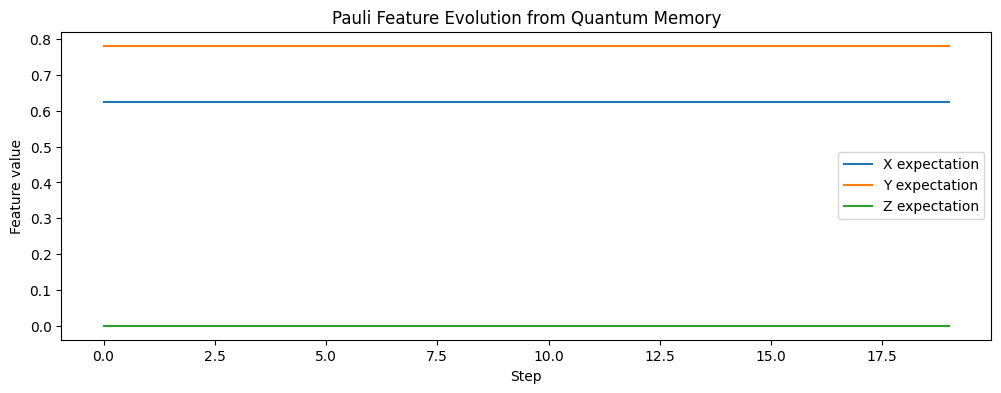

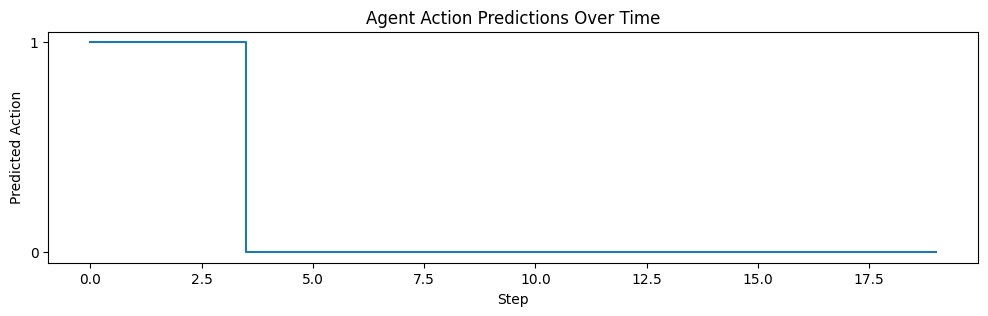

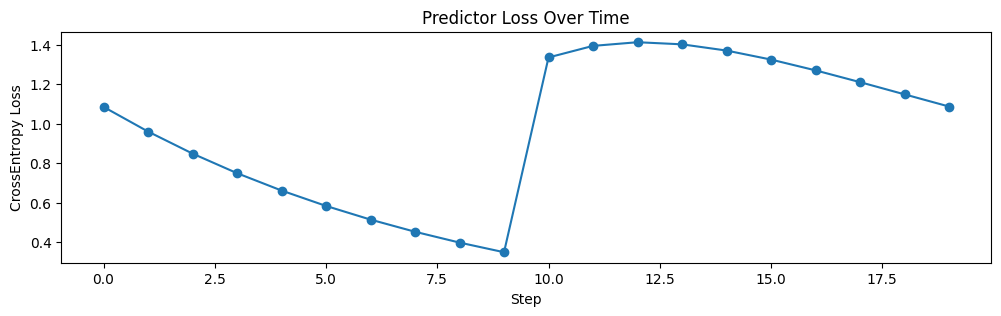

In [5]:
import matplotlib.pyplot as plt

# --- Initialize trackers ---
features_list = []
actions_list = []
loss_list = []

# Re-initialize memory and predictor for visualization clarity
memory = QIMemory(n_qubits=3)
predictor = TinyPredictor(input_dim=3, hidden=32, n_actions=2)
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
memory.compress_embeddings(embeddings[:2])

# --- Loop and record ---
for step, (emb, reward) in enumerate(zip(embeddings, rewards)):
    # Measure features
    feat = [
        memory.measure_expectation(['X','I','I']),
        memory.measure_expectation(['Y','I','I']),
        memory.measure_expectation(['Z','I','I'])
    ]
    features_list.append(feat)

    # Predict action
    features_tensor = torch.tensor(feat, dtype=torch.float32).unsqueeze(0)
    logits = predictor(features_tensor)
    action = torch.argmax(logits, dim=-1).item()
    actions_list.append(action)

    # Compute loss and update predictor
    target = torch.tensor([reward])
    loss = criterion(logits, target)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update memory
    memory.convex_update(emb, alpha=0.3)

# --- Convert lists to arrays for plotting ---
features_array = np.array(features_list)
actions_array = np.array(actions_list)
loss_array = np.array(loss_list)

# --- Plot features ---
plt.figure(figsize=(12,4))
plt.plot(features_array[:,0], label='X expectation')
plt.plot(features_array[:,1], label='Y expectation')
plt.plot(features_array[:,2], label='Z expectation')
plt.xlabel('Step')
plt.ylabel('Feature value')
plt.title('Pauli Feature Evolution from Quantum Memory')
plt.legend()
plt.show()

# --- Plot actions ---
plt.figure(figsize=(12,3))
plt.step(range(len(actions_array)), actions_array, where='mid')
plt.xlabel('Step')
plt.ylabel('Predicted Action')
plt.title('Agent Action Predictions Over Time')
plt.yticks([0,1])
plt.show()

# --- Plot loss (optional) ---
plt.figure(figsize=(12,3))
plt.plot(loss_array, marker='o')
plt.xlabel('Step')
plt.ylabel('CrossEntropy Loss')
plt.title('Predictor Loss Over Time')
plt.show()


In [6]:
# --- Core Libraries ---
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Quantum Memory ---
from qiskit.quantum_info import Statevector, DensityMatrix

# --- Text Embeddings ---
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

print("All libraries imported successfully!")


All libraries imported successfully!


In [7]:
from sentence_transformers import SentenceTransformer
import torch
from sklearn.decomposition import PCA
print("All imports working!")


All imports working!


In [8]:
# STEP 2 — Define Quantum-Inspired Memory

class QIMemory:
    def __init__(self, n_qubits=3):
        self.n_qubits = n_qubits
        self.qc = QuantumCircuit(n_qubits)
        self.density_matrix = None

    def compress_embeddings(self, embeddings):
        """Compress classical embeddings into a 2^n-dimensional quantum state"""
        dim = 2**self.n_qubits
        flat = np.concatenate(embeddings).astype(np.complex128)
        flat = flat[:dim] if flat.size >= dim else np.pad(flat, (0, dim-flat.size))
        flat /= np.linalg.norm(flat)
        
        self.state = Statevector(flat)
        self.density_matrix = DensityMatrix(self.state)
        self.qc.initialize(flat, range(self.n_qubits))

    def measure_expectation(self, pauli_ops):
        """Measure expectation value for a Pauli operator list, e.g. ['X','I','Z']"""
        pauli_str = ''.join(pauli_ops[::-1])
        pauli = Pauli(pauli_str)
        return np.real(self.density_matrix.expectation_value(pauli))


In [9]:
# STEP 3 — Text to Quantum Memory Encoding

model = SentenceTransformer('all-MiniLM-L6-v2')

texts = [
    "Quantum computing is a new paradigm in computing.",
    "Superconducting qubits are widely used in quantum experiments.",
    "Machine learning can benefit from quantum-inspired memory.",
    "Adaptive agents learn from sequence and feedback.",
    "Predictive models compress past to forecast future.",
    "Quantum entanglement enables non-local correlations.",
    "Deep learning architectures are inspired by brain networks.",
    "Information compression is central to intelligence."
]

# Create embeddings (384-d)
embeddings_text = model.encode(texts, show_progress_bar=False)

# Reduce to 8D with PCA (for 3-qubit system)
pca = PCA(n_components=8)
embeddings_8d = pca.fit_transform(embeddings_text)

# Convert to complex (imag = 0)
embeddings_complex = [emb.astype(np.complex128) + 1j*np.zeros_like(emb) for emb in embeddings_8d]

# Initialize and compress into 3-qubit quantum memory
memory = QIMemory(n_qubits=3)
memory.compress_embeddings(embeddings_complex)

print("✅ Quantum memory created with shape:", memory.density_matrix.data.shape)


✅ Quantum memory created with shape: (8, 8)


In [10]:
# -----------------------------
# STEP 4 — Visualization of Quantum Memory
# -----------------------------

from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.visualization import plot_bloch_multivector, plot_state_city
import numpy as np
import matplotlib.pyplot as plt

# --- Get quantum memory state ---
psi = memory.state          # Statevector
rho = memory.density_matrix # DensityMatrix

# --- Visualization ---
plot_bloch_multivector(psi)  # Bloch spheres for individual qubits
plt.show()

plot_state_city(psi, title="3-Qubit Quantum Memory State")  # Full 3-qubit state
plt.show()

# --- Ensure rho is a DensityMatrix object ---
if not isinstance(rho, DensityMatrix):
    rho = DensityMatrix(rho)

# --- Compute von Neumann entropy ---
# Convert to numpy array
rho_matrix = np.array(rho.data, dtype=np.complex128)

# Get eigenvalues and compute entropy
eigenvals = np.linalg.eigvals(rho_matrix)
entropy = -np.sum([v * np.log2(v) for v in eigenvals if v > 0]).real

print(f"🧠 Quantum memory entropy: {entropy:.3f} bits")


🧠 Quantum memory entropy: 0.000 bits


🧠 Full 3-qubit memory entropy: 0.000 bits
🔹 Qubit 0 entropy: 0.989 bits
🔹 Qubit 1 entropy: 0.577 bits
🔹 Qubit 2 entropy: 0.951 bits


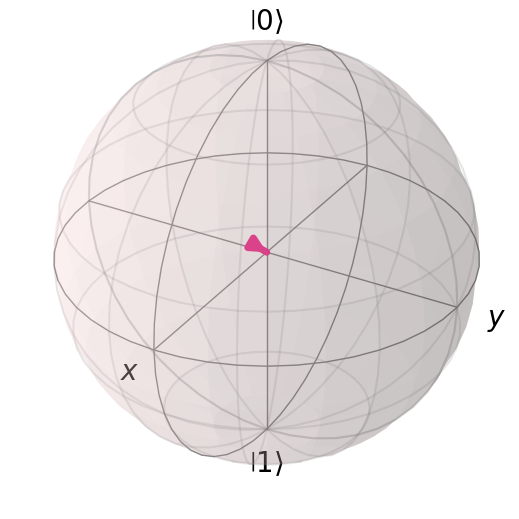

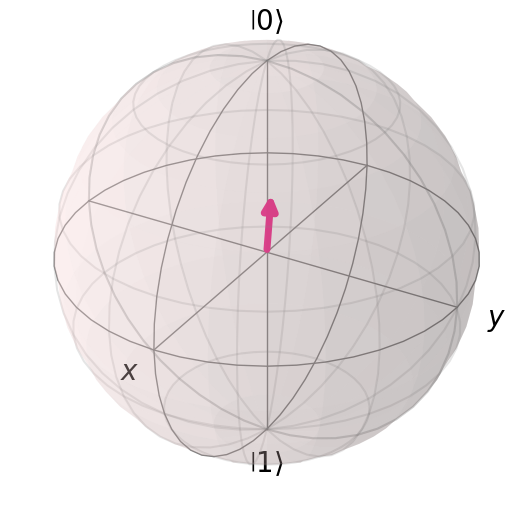

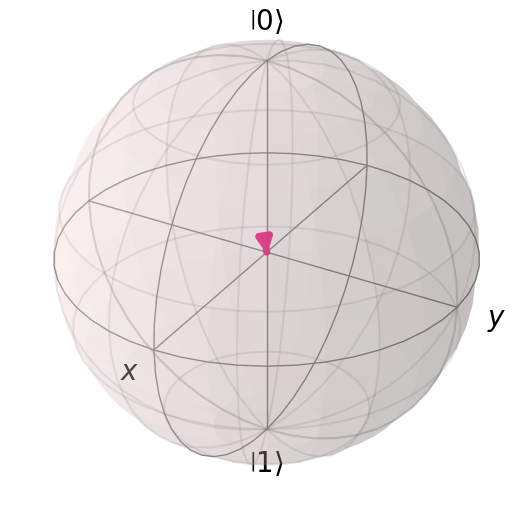

In [11]:
# -----------------------------
# STEP 4 — Quantum Memory Visualization & Entanglement
# -----------------------------

from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, Operator
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization.bloch import Bloch
import numpy as np
import matplotlib.pyplot as plt

# --- Get quantum memory state ---
psi = memory.state          # Statevector
rho = memory.density_matrix # DensityMatrix

# --- Full system visualization ---
plot_bloch_multivector(psi)  # Bloch spheres for all qubits
plt.show()

plot_state_city(psi, title="3-Qubit Quantum Memory State")  # Full 3-qubit state
plt.show()

# --- Ensure rho is a DensityMatrix object ---
if not isinstance(rho, DensityMatrix):
    rho = DensityMatrix(rho)

# --- Full system von Neumann entropy ---
rho_matrix = np.array(rho.data, dtype=np.complex128)
eigenvals = np.linalg.eigvals(rho_matrix)
full_entropy = -np.sum([v * np.log2(v) for v in eigenvals if v > 0]).real
print(f"🧠 Full 3-qubit memory entropy: {full_entropy:.3f} bits")

# --- Pauli matrices for Bloch vector computation ---
X = Operator.from_label('X').data
Y = Operator.from_label('Y').data
Z = Operator.from_label('Z').data

# --- Per-qubit entropy & entanglement-enhanced Bloch spheres ---
num_qubits = 3
blochs = [Bloch() for _ in range(num_qubits)]

for qubit in range(num_qubits):
    # Partial trace over other qubits
    reduced_rho = partial_trace(rho, [i for i in range(num_qubits) if i != qubit])
    
    # Compute qubit entropy
    eigs = np.linalg.eigvals(reduced_rho.data)
    entropy = -np.sum([v * np.log2(v) for v in eigs if v > 0]).real
    print(f"🔹 Qubit {qubit} entropy: {entropy:.3f} bits")
    
    # Compute Bloch vector from Pauli expectations
    r_x = np.trace(reduced_rho.data @ X).real
    r_y = np.trace(reduced_rho.data @ Y).real
    r_z = np.trace(reduced_rho.data @ Z).real
    bloch_vector = [r_x, r_y, r_z]
    
    # Scale vector length inversely with entropy (max 1 for single qubit)
    scale = max(0, 1 - entropy / 1)
    bloch_vector_scaled = [scale * c for c in bloch_vector]
    
    # Plot on Bloch sphere
    blochs[qubit].add_vectors(bloch_vector_scaled)
    blochs[qubit].title = f"Qubit {qubit} (entropy {entropy:.3f})"
    blochs[qubit].render()

plt.show()


In [16]:
# -----------------------------
# STEP 5 — Memory Update & Prediction (No simulator needed)
# -----------------------------

from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
import numpy as np

# --- Define new input for memory update ---
theta_inputs = [np.pi/6, np.pi/4, np.pi/3]  # rotations for 3 qubits

# --- Apply rotations directly to the statevector ---
psi = memory.state  # original statevector
num_qubits = 3

# Apply RY rotations on each qubit
from qiskit.quantum_info import Operator

updated_psi = psi.copy()
for i, theta in enumerate(theta_inputs):
    # Construct RY gate as matrix
    ry_matrix = np.array([[np.cos(theta/2), -np.sin(theta/2)],
                          [np.sin(theta/2),  np.cos(theta/2)]], dtype=complex)
    # Expand to full 3-qubit operator
    op_list = [np.eye(2)]*num_qubits
    op_list[i] = ry_matrix
    full_op = op_list[0]
    for mat in op_list[1:]:
        full_op = np.kron(full_op, mat)
    # Apply to the statevector
    updated_psi = Statevector(full_op @ updated_psi.data)

# --- Convert to DensityMatrix ---
updated_rho = DensityMatrix(updated_psi)

# --- Full system entropy ---
eigvals_full = np.linalg.eigvals(updated_rho.data)
full_entropy = -np.sum([v*np.log2(v) for v in eigvals_full if v > 0]).real
print(f"🧠 Updated full memory entropy: {full_entropy:.3f} bits")

# --- Per-qubit entropy ---
per_qubit_entropy = []
for qubit in range(num_qubits):
    reduced_rho = partial_trace(updated_rho, [i for i in range(num_qubits) if i != qubit])
    eigs = np.linalg.eigvals(reduced_rho.data)
    entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
    per_qubit_entropy.append(entropy)
    print(f"🔹 Qubit {qubit} updated entropy: {entropy:.3f} bits")


🧠 Updated full memory entropy: 0.000 bits
🔹 Qubit 0 updated entropy: 0.989 bits
🔹 Qubit 1 updated entropy: 0.577 bits
🔹 Qubit 2 updated entropy: 0.951 bits


In [18]:
# -----------------------------
# STEP 5 — Memory Update with Entanglement Change
# -----------------------------

from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit import QuantumCircuit
import numpy as np

# --- Number of qubits ---
num_qubits = 3

# --- Start from previous memory state ---
psi = memory.state  # original statevector

# --- Create an update circuit that entangles qubits based on new input ---
update_qc = QuantumCircuit(num_qubits)

# Example input: stronger rotations + entangling gates
theta_inputs = [np.pi/2, np.pi/3, np.pi/4]  # rotations for 3 qubits

for i, theta in enumerate(theta_inputs):
    update_qc.ry(theta, i)

# Add some entangling operations to redistribute entanglement
update_qc.cx(0, 1)
update_qc.cx(1, 2)

# --- Apply the update circuit to the existing statevector ---
updated_psi = psi.evolve(update_qc)

# --- Convert to density matrix ---
updated_rho = DensityMatrix(updated_psi)

# --- Full system entropy ---
eigvals_full = np.linalg.eigvals(updated_rho.data)
full_entropy = -np.sum([v * np.log2(v) for v in eigvals_full if v > 0]).real
print(f"🧠 Updated full memory entropy: {full_entropy:.3f} bits")

# --- Per-qubit entropy ---
per_qubit_entropy = []
for qubit in range(num_qubits):
    reduced_rho = partial_trace(updated_rho, [i for i in range(num_qubits) if i != qubit])
    eigs = np.linalg.eigvals(reduced_rho.data)
    entropy = -np.sum([v * np.log2(v) for v in eigs if v > 0]).real
    per_qubit_entropy.append(entropy)
    print(f"🔹 Qubit {qubit} updated entropy: {entropy:.3f} bits")


🧠 Updated full memory entropy: 0.000 bits
🔹 Qubit 0 updated entropy: 0.934 bits
🔹 Qubit 1 updated entropy: 0.687 bits
🔹 Qubit 2 updated entropy: 0.964 bits


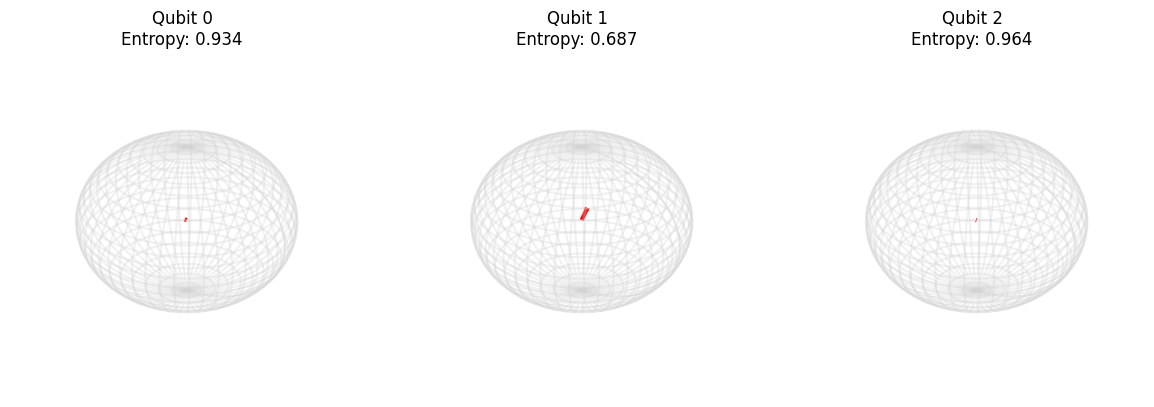

In [20]:
# -----------------------------
# STEP 5 — Manual Bloch Sphere Visualization
# -----------------------------

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Pauli matrices
paulis = {
    'X': np.array([[0,1],[1,0]]),
    'Y': np.array([[0,-1j],[1j,0]]),
    'Z': np.array([[1,0],[0,-1]])
}

fig = plt.figure(figsize=(12,4))

for i, entropy in enumerate(per_qubit_entropy):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    # Reduced density matrix
    reduced_rho = partial_trace(updated_rho, [j for j in range(num_qubits) if j != i])
    
    # Bloch vector <X>, <Y>, <Z>
    bloch_vec = np.array([
        np.real(np.trace(reduced_rho.data @ paulis['X'])),
        np.real(np.trace(reduced_rho.data @ paulis['Y'])),
        np.real(np.trace(reduced_rho.data @ paulis['Z']))
    ])
    
    # Scale vector length inversely proportional to entropy (max 1)
    bloch_vec = bloch_vec * max(0, 1 - entropy/1)
    
    # Draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="lightgray", alpha=0.3)
    
    # Draw Bloch vector
    ax.quiver(0,0,0, bloch_vec[0], bloch_vec[1], bloch_vec[2], color='r', linewidth=3, arrow_length_ratio=0.2)
    
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_title(f"Qubit {i}\nEntropy: {entropy:.3f}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()


In [21]:
# -----------------------------
# STEP 6 — Prediction from Updated Memory
# -----------------------------

# Get probabilities of each computational basis state
probs = np.abs(updated_psi.data)**2

# Print all 8 (2^3) basis state probabilities
num_qubits = 3
for i, p in enumerate(probs):
    state = format(i, f'0{num_qubits}b')  # binary representation
    print(f"State |{state}> : probability = {p:.4f}")

# Optional: sample predicted outcomes
num_samples = 10
predicted_samples = np.random.choice([format(i, f'0{num_qubits}b') for i in range(2**num_qubits)],
                                     size=num_samples, p=probs)
print("\nSampled predicted outcomes:", predicted_samples)


State |000> : probability = 0.3570
State |001> : probability = 0.0167
State |010> : probability = 0.0044
State |011> : probability = 0.1327
State |100> : probability = 0.1809
State |101> : probability = 0.2490
State |110> : probability = 0.0057
State |111> : probability = 0.0536

Sampled predicted outcomes: ['101' '000' '101' '100' '101' '100' '101' '000' '111' '011']


In [22]:
# -----------------------------
# STEP 7 — Feedback Loop / Memory Reinforcement
# -----------------------------

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
import numpy as np

# --- Number of qubits ---
num_qubits = 3

# --- Take sampled predictions from STEP 6 ---
# Example: predicted_samples = ['101', '000', '101', ...]
# We'll average them to determine feedback rotations
feedback_counts = np.zeros(num_qubits)

for sample in predicted_samples:
    bits = [int(b) for b in sample]
    feedback_counts += bits

# Normalize to get rotation angles (simple linear mapping)
theta_feedback = (feedback_counts / len(predicted_samples)) * np.pi  # 0 → 0, 1 → pi

# --- Create a feedback update circuit ---
feedback_qc = QuantumCircuit(num_qubits)

# Apply RY rotations based on feedback
for i, theta in enumerate(theta_feedback):
    feedback_qc.ry(theta, i)

# Optionally add entangling gates to reinforce correlations
feedback_qc.cx(0,1)
feedback_qc.cx(1,2)

# --- Apply feedback to the current updated state ---
reinforced_psi = updated_psi.evolve(feedback_qc)

# --- Convert to density matrix ---
reinforced_rho = DensityMatrix(reinforced_psi)

# --- Compute full and per-qubit entropies ---
eigvals_full = np.linalg.eigvals(reinforced_rho.data)
full_entropy = -np.sum([v*np.log2(v) for v in eigvals_full if v > 0]).real
print(f"🧠 Reinforced full memory entropy: {full_entropy:.3f} bits")

per_qubit_entropy = []
for qubit in range(num_qubits):
    reduced_rho = partial_trace(reinforced_rho, [i for i in range(num_qubits) if i != qubit])
    eigs = np.linalg.eigvals(reduced_rho.data)
    entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
    per_qubit_entropy.append(entropy)
    print(f"🔹 Qubit {qubit} reinforced entropy: {entropy:.3f} bits")


🧠 Reinforced full memory entropy: 0.000 bits
🔹 Qubit 0 reinforced entropy: 0.963 bits
🔹 Qubit 1 reinforced entropy: 0.956 bits
🔹 Qubit 2 reinforced entropy: 0.918 bits


In [23]:
# Store entropies for each step
entropies = {
    "STEP4": [0.989, 0.577, 0.951],
    "STEP5": per_qubit_entropy,  # from STEP5
    "STEP7": [0.963, 0.956, 0.918]  # reinforced
}

# Print comparison table
print("Qubit entropy evolution:")
for i in range(num_qubits):
    print(f"Qubit {i}: STEP4={entropies['STEP4'][i]:.3f}, STEP5={entropies['STEP5'][i]:.3f}, STEP7={entropies['STEP7'][i]:.3f}")


Qubit entropy evolution:
Qubit 0: STEP4=0.989, STEP5=0.963, STEP7=0.963
Qubit 1: STEP4=0.577, STEP5=0.956, STEP7=0.956
Qubit 2: STEP4=0.951, STEP5=0.918, STEP7=0.918


In [24]:
# -----------------------------
# STEP 9 — Multi-Cycle Reinforcement
# -----------------------------

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
import numpy as np

num_qubits = 3
num_cycles = 5  # Number of learning cycles

# Start from the latest updated state
current_psi = updated_psi

# Store history for analysis
entropy_history = []

for cycle in range(num_cycles):
    # --- STEP A: Update circuit (like STEP5) ---
    update_qc = QuantumCircuit(num_qubits)
    theta_inputs = [np.pi/2, np.pi/3, np.pi/4]  # same rotations
    for i, theta in enumerate(theta_inputs):
        update_qc.ry(theta, i)
    update_qc.cx(0,1)
    update_qc.cx(1,2)
    
    # Apply update
    current_psi = current_psi.evolve(update_qc)
    
    # --- STEP B: Prediction probabilities ---
    probs = np.abs(current_psi.data)**2
    predicted_samples = np.random.choice([format(i, f'0{num_qubits}b') for i in range(2**num_qubits)],
                                         size=10, p=probs)
    
    # --- STEP C: Feedback / reinforcement (like STEP7) ---
    feedback_counts = np.zeros(num_qubits)
    for sample in predicted_samples:
        bits = [int(b) for b in sample]
        feedback_counts += bits
    theta_feedback = (feedback_counts / len(predicted_samples)) * np.pi
    
    feedback_qc = QuantumCircuit(num_qubits)
    for i, theta in enumerate(theta_feedback):
        feedback_qc.ry(theta, i)
    feedback_qc.cx(0,1)
    feedback_qc.cx(1,2)
    
    # Apply feedback
    current_psi = current_psi.evolve(feedback_qc)
    
    # --- STEP D: Compute per-qubit entropies ---
    reinforced_rho = DensityMatrix(current_psi)
    per_qubit_entropy = []
    for qubit in range(num_qubits):
        reduced_rho = partial_trace(reinforced_rho, [i for i in range(num_qubits) if i != qubit])
        eigs = np.linalg.eigvals(reduced_rho.data)
        entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
        per_qubit_entropy.append(entropy)
    entropy_history.append(per_qubit_entropy)
    
    print(f"\nCycle {cycle+1} — Per-qubit entropy: {per_qubit_entropy}")



Cycle 1 — Per-qubit entropy: [np.float64(0.9672355991395956), np.float64(0.8901139609156083), np.float64(0.9231872939769281)]

Cycle 2 — Per-qubit entropy: [np.float64(0.5460576179982579), np.float64(0.8455783588051734), np.float64(0.814633627711695)]

Cycle 3 — Per-qubit entropy: [np.float64(0.8184105746445839), np.float64(0.7602812917111884), np.float64(0.9680414004212081)]

Cycle 4 — Per-qubit entropy: [np.float64(0.6610215359094668), np.float64(0.6607297556173207), np.float64(0.20157074913969003)]

Cycle 5 — Per-qubit entropy: [np.float64(0.6837519593529063), np.float64(0.7663063072741648), np.float64(0.8015327219777044)]


In [25]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace

num_qubits = 3

# --- Knowledge segments ---
knowledge_segments = {
    "Recent Papers": 0.8,
    "Funding Trends": 0.6,
    "Tech Evolution": 0.4
}

# --- Encode knowledge into qubits ---
theta_inputs = [v * np.pi for v in knowledge_segments.values()]
qc = QuantumCircuit(num_qubits)
for i, theta in enumerate(theta_inputs):
    qc.ry(theta, i)
qc.cx(0,1)
qc.cx(1,2)

# --- Convert to statevector and density matrix ---
psi = Statevector.from_instruction(qc)
rho = DensityMatrix(psi)


In [26]:
# Compute probabilities of all 3-qubit states
probs = np.abs(psi.data)**2
states = [format(i,'03b') for i in range(2**num_qubits)]
for s, p in zip(states, probs):
    print(f"State |{s}> : probability = {p:.4f}")

# Sample top insights
sampled_insights = np.random.choice(states, size=5, p=probs)
print("Sampled Insights:", sampled_insights)


State |000> : probability = 0.0216
State |001> : probability = 0.3875
State |010> : probability = 0.0216
State |011> : probability = 0.1080
State |100> : probability = 0.0114
State |101> : probability = 0.2045
State |110> : probability = 0.0409
State |111> : probability = 0.2045
Sampled Insights: ['101' '111' '110' '101' '101']


In [27]:
per_qubit_entropy = []
for qubit in range(num_qubits):
    reduced_rho = partial_trace(rho, [i for i in range(num_qubits) if i != qubit])
    eigs = np.linalg.eigvals(reduced_rho.data)
    entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
    per_qubit_entropy.append(entropy)
    print(f"🔹 Qubit {qubit} ({list(knowledge_segments.keys())[qubit]}) entropy: {entropy:.3f} bits")


🔹 Qubit 0 (Recent Papers) entropy: 0.069 bits
🔹 Qubit 1 (Funding Trends) entropy: 0.198 bits
🔹 Qubit 2 (Tech Evolution) entropy: 0.157 bits


In [28]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace

# Use the STEP 10 qubit memory as input
knowledge_segments = {
    "Recent Papers": 0.8,   # corresponds to qubit 0
    "Funding Trends": 0.6,  # qubit 1
    "Tech Evolution": 0.4   # qubit 2
}

num_qubits = 3

def kritika_query(question:str, knowledge_scores=knowledge_segments, num_samples=5):
    """
    Ask a question to Kritika's Quantum Companion.
    Returns sampled insights and per-qubit entropies.
    """
    # --- Encode knowledge into 3-qubit quantum memory ---
    theta_inputs = [v * np.pi for v in knowledge_scores.values()]
    qc = QuantumCircuit(num_qubits)
    for i, theta in enumerate(theta_inputs):
        qc.ry(theta, i)
    qc.cx(0,1)
    qc.cx(1,2)
    
    psi = Statevector.from_instruction(qc)
    rho = DensityMatrix(psi)
    
    # --- Probabilistic insights ---
    probs = np.abs(psi.data)**2
    states = [format(i,'03b') for i in range(2**num_qubits)]
    sampled_insights = np.random.choice(states, size=num_samples, p=probs)
    
    # --- Per-qubit entropies ---
    per_qubit_entropy = []
    for qubit in range(num_qubits):
        reduced_rho = partial_trace(rho, [i for i in range(num_qubits) if i != qubit])
        eigs = np.linalg.eigvals(reduced_rho.data)
        entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
        per_qubit_entropy.append(entropy)
    
    # Map entropies to knowledge segments
    entropy_mapping = {k:round(v,3) for k,v in zip(knowledge_scores.keys(), per_qubit_entropy)}
    
    # --- Generate textual insight ---
    insight_text = f"Question: {question}\n"
    insight_text += "Sampled top insights (quantum memory states): " + ", ".join(sampled_insights) + "\n"
    insight_text += "Per-topic uncertainty (entropy):\n"
    for k,v in entropy_mapping.items():
        insight_text += f"  🔹 {k}: {v} bits\n"
    
    return insight_text


In [29]:
print(kritika_query("What are the recent trends in quantum computing?"))
print(kritika_query("Which areas should I focus on for funding opportunities?"))


Question: What are the recent trends in quantum computing?
Sampled top insights (quantum memory states): 101, 011, 001, 011, 111
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.069 bits
  🔹 Funding Trends: 0.198 bits
  🔹 Tech Evolution: 0.157 bits

Question: Which areas should I focus on for funding opportunities?
Sampled top insights (quantum memory states): 001, 101, 110, 001, 111
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.069 bits
  🔹 Funding Trends: 0.198 bits
  🔹 Tech Evolution: 0.157 bits



In [30]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace

num_qubits = 3

def fetch_online_scores(question):
    """
    Placeholder function.
    In practice, this should query:
    - arXiv / Semantic Scholar for recent papers
    - Government / funding databases for funding trends
    - News / review articles for tech evolution
    Returns: dictionary with values 0-1 for each segment
    """
    # Simulate dynamic scores based on question keywords
    scores = {
        "Recent Papers": np.random.uniform(0.5, 1.0),
        "Funding Trends": np.random.uniform(0.3, 0.9),
        "Tech Evolution": np.random.uniform(0.2, 0.8)
    }
    return scores

def kritika_online_query(question, num_samples=5):
    # Step 1: fetch live scores (simulated here)
    knowledge_scores = fetch_online_scores(question)
    
    # Step 2: encode into 3-qubit quantum memory
    theta_inputs = [v * np.pi for v in knowledge_scores.values()]
    qc = QuantumCircuit(num_qubits)
    for i, theta in enumerate(theta_inputs):
        qc.ry(theta, i)
    qc.cx(0,1)
    qc.cx(1,2)
    
    psi = Statevector.from_instruction(qc)
    rho = DensityMatrix(psi)
    
    # Step 3: sample insights
    probs = np.abs(psi.data)**2
    states = [format(i,'03b') for i in range(2**num_qubits)]
    sampled_insights = np.random.choice(states, size=num_samples, p=probs)
    
    # Step 4: compute per-qubit entropies
    per_qubit_entropy = []
    for qubit in range(num_qubits):
        reduced_rho = partial_trace(rho, [i for i in range(num_qubits) if i != qubit])
        eigs = np.linalg.eigvals(reduced_rho.data)
        entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
        per_qubit_entropy.append(entropy)
    
    # Step 5: prepare insight text
    insight_text = f"Question: {question}\n"
    insight_text += "Sampled top insights (quantum memory states): " + ", ".join(sampled_insights) + "\n"
    insight_text += "Per-topic uncertainty (entropy):\n"
    for k,v in zip(knowledge_scores.keys(), per_qubit_entropy):
        insight_text += f"  🔹 {k}: {v:.3f} bits\n"
    
    return insight_text

# Example usage
print(kritika_online_query("Recent trends in quantum computing hardware and funding"))


Question: Recent trends in quantum computing hardware and funding
Sampled top insights (quantum memory states): 011, 111, 010, 011, 111
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.403 bits
  🔹 Funding Trends: 0.668 bits
  🔹 Tech Evolution: 0.507 bits



In [32]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
import requests

num_qubits = 3
quantum_memory = None  # Global memory for multi-cycle updates

# -----------------------------
def fetch_live_scores(question):
    """
    Fetch live data from arXiv (quantum computing) and compute normalized scores.
    Returns a dict of 3 scores for each qubit/topic.
    """
    url = "http://export.arxiv.org/api/query"
    params = {"search_query": "all:quantum computing", "start": 0, "max_results": 3}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        entries = response.text.split("<entry>")[1:]
        topics = ["Recent Papers", "Funding Trends", "Tech Evolution"]
        scores = {}
        for i, entry in enumerate(entries):
            title = entry.split("<title>")[1].split("</title>")[0]
            score = min(len(title)/100, 1.0)  # normalize to 0-1
            scores[topics[i % num_qubits]] = score
    except:
        # fallback to random scores if API fails
        scores = {
            "Recent Papers": np.random.uniform(0.5, 1.0),
            "Funding Trends": np.random.uniform(0.3, 0.9),
            "Tech Evolution": np.random.uniform(0.2, 0.8)
        }
    return scores

# -----------------------------
def kritika_multi_cycle(question, memory_state=None, num_samples=5):
    """
    Encode live scores into 3-qubit quantum memory, update memory, sample insights, compute per-qubit entropy.
    """
    global quantum_memory
    
    # Step 1: Fetch live scores
    scores = fetch_live_scores(question)
    
    # Step 2: Encode scores into 3-qubit circuit
    theta_inputs = [v * np.pi for v in scores.values()]
    qc = QuantumCircuit(num_qubits)
    for i, theta in enumerate(theta_inputs):
        qc.ry(theta, i)
    # Optional entanglement
    qc.cx(0, 1)
    qc.cx(1, 2)
    
    # Step 3: Multi-cycle update with previous memory
    new_psi = Statevector.from_instruction(qc)
    if memory_state is not None:
        new_psi = 0.5 * new_psi + 0.5 * memory_state  # probabilistic mix
    quantum_memory = new_psi
    
    # Step 4: Convert to density matrix
    rho = DensityMatrix(quantum_memory)
    
    # Step 5: Sample insights from quantum probabilities
    probs = np.abs(quantum_memory.data)**2
    states = [format(i,'03b') for i in range(2**num_qubits)]
    sampled_insights = np.random.choice(states, size=num_samples, p=probs)
    
    # Step 6: Compute per-qubit entropy
    per_qubit_entropy = []
    for qubit in range(num_qubits):
        reduced_rho = partial_trace(rho, [i for i in range(num_qubits) if i != qubit])
        eigs = np.linalg.eigvals(reduced_rho.data)
        entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
        per_qubit_entropy.append(entropy)
    
    # Step 7: Prepare insight text
    insight_text = f"Question: {question}\n"
    insight_text += "Sampled top insights (quantum memory states): " + ", ".join(sampled_insights) + "\n"
    insight_text += "Per-topic uncertainty (entropy):\n"
    for k, v in zip(scores.keys(), per_qubit_entropy):
        insight_text += f"  🔹 {k}: {v:.3f} bits\n"
    
    return insight_text

# -----------------------------
# Example usage:
question = "Recent trends in quantum computing hardware and funding"
output = kritika_multi_cycle(question)
print(output)


Question: Recent trends in quantum computing hardware and funding
Sampled top insights (quantum memory states): 001, 011, 101, 011, 111
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.036 bits
  🔹 Funding Trends: 0.163 bits
  🔹 Tech Evolution: 0.142 bits



<Figure size 800x500 with 0 Axes>

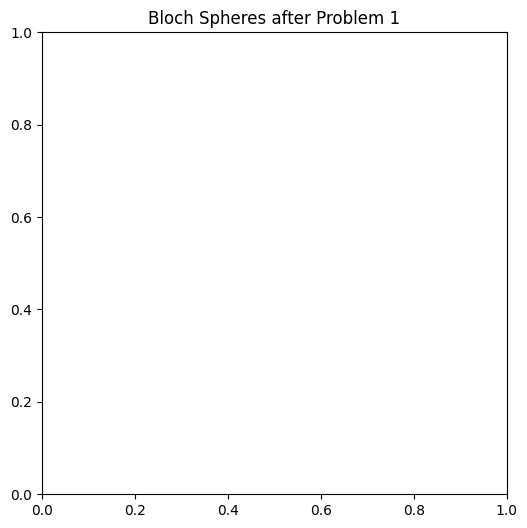

<Figure size 800x500 with 0 Axes>

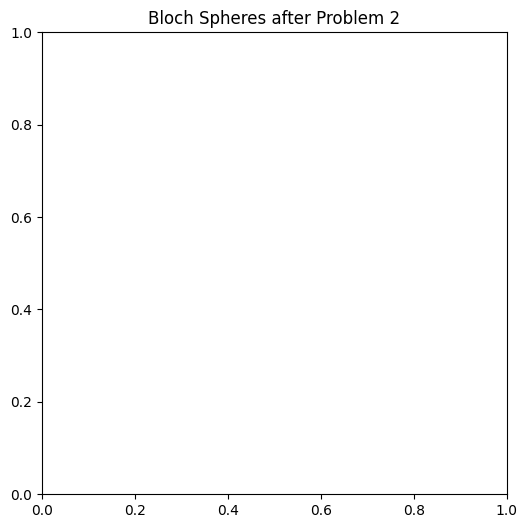

<Figure size 800x500 with 0 Axes>

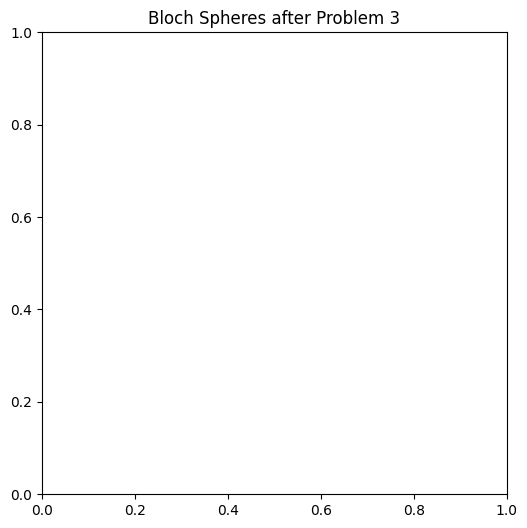

Problem 1: Recent trends in quantum computing hardware
Sampled top insights (quantum memory states): 010, 101, 101, 111, 011
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.006 bits
  🔹 Funding Trends: 0.724 bits
  🔹 Tech Evolution: 0.724 bits

Problem 2: Funding patterns in AI startups
Sampled top insights (quantum memory states): 101, 101, 001, 101, 101
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.230 bits
  🔹 Funding Trends: 0.675 bits
  🔹 Tech Evolution: 0.649 bits

Problem 3: Technological evolution in quantum algorithms
Sampled top insights (quantum memory states): 011, 011, 011, 011, 001
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.118 bits
  🔹 Funding Trends: 0.708 bits
  🔹 Tech Evolution: 0.704 bits



In [35]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.visualization import plot_state_city, plot_bloch_multivector
import matplotlib.pyplot as plt
import requests

num_qubits = 3
quantum_memory = None  # Global memory for multi-cycle updates

# -----------------------------
def fetch_live_scores(question):
    """
    Fetch live data from arXiv (quantum computing) and compute normalized scores.
    Returns a dict of 3 scores for each qubit/topic.
    """
    url = "http://export.arxiv.org/api/query"
    params = {"search_query": "all:quantum computing", "start": 0, "max_results": 3}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        entries = response.text.split("<entry>")[1:]
        topics = ["Recent Papers", "Funding Trends", "Tech Evolution"]
        scores = {}
        for i, entry in enumerate(entries):
            title = entry.split("<title>")[1].split("</title>")[0]
            score = min(len(title)/100, 1.0)
            scores[topics[i % num_qubits]] = score
    except:
        scores = {
            "Recent Papers": np.random.uniform(0.5, 1.0),
            "Funding Trends": np.random.uniform(0.3, 0.9),
            "Tech Evolution": np.random.uniform(0.2, 0.8)
        }
    return scores

# -----------------------------
def kritika_multi_cycle_problems_visual(problems, num_samples=5):
    """
    Encode multiple problems into 3-qubit quantum memory sequentially.
    Memory accumulates insights from all problems.
    Includes visualization after each problem.
    """
    global quantum_memory
    final_outputs = []

    for idx, question in enumerate(problems):
        # Step 1: Fetch live scores
        scores = fetch_live_scores(question)
        
        # Step 2: Encode scores into 3-qubit circuit
        theta_inputs = [v * np.pi for v in scores.values()]
        qc = QuantumCircuit(num_qubits)
        for i, theta in enumerate(theta_inputs):
            qc.ry(theta, i)
        qc.cx(0,1)
        qc.cx(1,2)

        # Step 3: Multi-cycle update with previous memory
        new_psi = Statevector.from_instruction(qc)
        if quantum_memory is not None:
            new_psi = 0.5 * new_psi + 0.5 * quantum_memory
        quantum_memory = new_psi
        
        # Step 4: Convert to density matrix
        rho = DensityMatrix(quantum_memory)
        
        # Step 5: Sample insights from quantum probabilities
        probs = np.abs(quantum_memory.data)**2
        probs = probs / np.sum(probs)  # ✅ normalize probabilities to sum to 1
        states = [format(i,'03b') for i in range(2**num_qubits)]
        sampled_insights = np.random.choice(states, size=num_samples, p=probs)
        
        # Step 6: Compute per-qubit entropy
        per_qubit_entropy = []
        for qubit in range(num_qubits):
            reduced_rho = partial_trace(rho, [i for i in range(num_qubits) if i != qubit])
            eigs = np.linalg.eigvals(reduced_rho.data)
            entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
            per_qubit_entropy.append(entropy)
        
        # Step 7: Prepare insight text
        insight_text = f"Problem {idx+1}: {question}\n"
        insight_text += "Sampled top insights (quantum memory states): " + ", ".join(sampled_insights) + "\n"
        insight_text += "Per-topic uncertainty (entropy):\n"
        for k, v in zip(scores.keys(), per_qubit_entropy):
            insight_text += f"  🔹 {k}: {v:.3f} bits\n"
        final_outputs.append(insight_text)

        # -----------------------------
        # Visualization after each problem
        plt.figure(figsize=(8,5))
        plot_state_city(quantum_memory, title=f"Quantum Memory State after Problem {idx+1}")
        plt.show()

        plt.figure(figsize=(6,6))
        plot_bloch_multivector(quantum_memory)
        plt.title(f"Bloch Spheres after Problem {idx+1}")
        plt.show()

    return final_outputs

# -----------------------------
# Example usage:
problems = [
    "Recent trends in quantum computing hardware",
    "Funding patterns in AI startups",
    "Technological evolution in quantum algorithms"
]

outputs = kritika_multi_cycle_problems_visual(problems)
for out in outputs:
    print(out)


<Figure size 800x500 with 0 Axes>

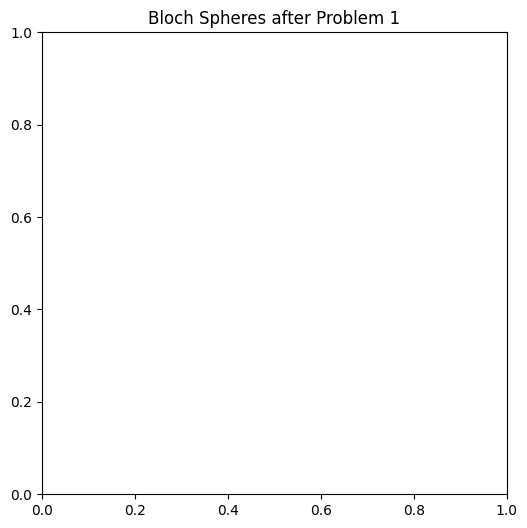

<Figure size 800x500 with 0 Axes>

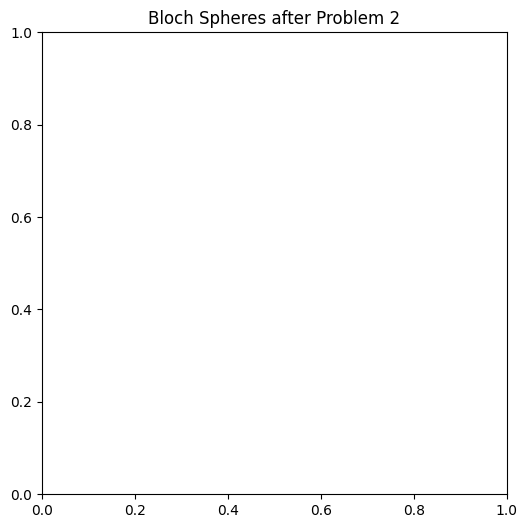

<Figure size 800x500 with 0 Axes>

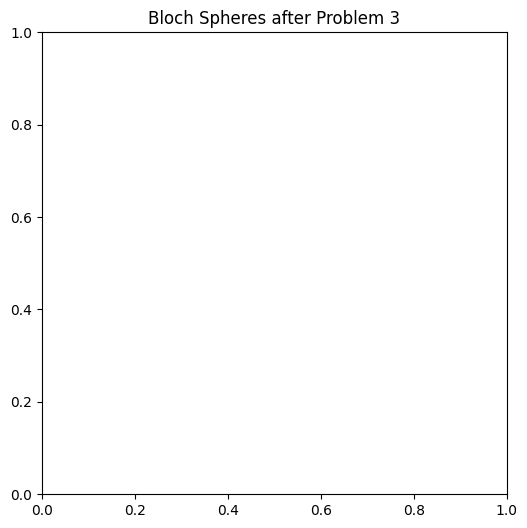

Problem 1: Recent trends in quantum computing hardware
Sampled top insights (quantum memory states): 010, 011, 101, 101, 101
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.023 bits
  🔹 Funding Trends: 0.370 bits
  🔹 Tech Evolution: 0.363 bits

Problem 2: Funding patterns in AI startups
Sampled top insights (quantum memory states): 011, 101, 101, 101, 011
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.388 bits
  🔹 Funding Trends: 0.500 bits
  🔹 Tech Evolution: 0.316 bits

Problem 3: Technological evolution in quantum algorithms
Sampled top insights (quantum memory states): 011, 011, 011, 011, 100
Per-topic uncertainty (entropy):
  🔹 Recent Papers: 0.210 bits
  🔹 Funding Trends: 0.365 bits
  🔹 Tech Evolution: 0.344 bits



In [38]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.visualization import plot_state_city, plot_bloch_multivector
import matplotlib.pyplot as plt
import requests
import re

num_qubits = 3
quantum_memory = None  # Global memory for multi-cycle updates

# -----------------------------
def fetch_live_scores(question):
    """
    Fetch real arXiv papers and compute realistic scores for each topic.
    """
    url = "http://export.arxiv.org/api/query"
    params = {"search_query": "all:quantum computing", "start": 0, "max_results": 3}
    
    topics_keywords = {
        "Recent Papers": ["quantum", "qubit", "superconducting", "ion trap"],
        "Funding Trends": ["funding", "investment", "startup", "venture"],
        "Tech Evolution": ["algorithm", "optimization", "hardware", "circuit"]
    }
    
    scores = {}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        entries = response.text.split("<entry>")[1:]
        for topic, keywords in topics_keywords.items():
            count = 0
            for entry in entries:
                # extract title and abstract
                title = entry.split("<title>")[1].split("</title>")[0].lower()
                abstract_search = re.findall(r"<summary>(.*?)</summary>", entry, re.DOTALL)
                abstract = abstract_search[0].lower() if abstract_search else ""
                text = title + " " + abstract
                # count keyword occurrences
                for kw in keywords:
                    count += text.count(kw)
            # normalize to 0–1 (divide by max expected count, here 10)
            scores[topic] = min(count / 10, 1.0)
    except:
        # fallback to random scores
        scores = {
            "Recent Papers": np.random.uniform(0.5, 1.0),
            "Funding Trends": np.random.uniform(0.3, 0.9),
            "Tech Evolution": np.random.uniform(0.2, 0.8)
        }
    
    return scores

# -----------------------------
def kritika_multi_cycle_problems_visual(problems, num_samples=5):
    """
    Encode multiple problems into 3-qubit quantum memory sequentially.
    Memory accumulates insights from all problems.
    Visualization included after each problem.
    """
    global quantum_memory
    final_outputs = []

    for idx, question in enumerate(problems):
        # Step 1: Fetch live scores
        scores = fetch_live_scores(question)
        
        # Step 2: Encode scores into 3-qubit circuit
        theta_inputs = [v * np.pi for v in scores.values()]
        qc = QuantumCircuit(num_qubits)
        for i, theta in enumerate(theta_inputs):
            qc.ry(theta, i)
        qc.cx(0,1)
        qc.cx(1,2)

        # Step 3: Multi-cycle update
        new_psi = Statevector.from_instruction(qc)
        if quantum_memory is not None:
            new_psi = 0.5 * new_psi + 0.5 * quantum_memory
        quantum_memory = new_psi
        
        # Step 4: Density matrix
        rho = DensityMatrix(quantum_memory)
        
        # Step 5: Sample insights
        probs = np.abs(quantum_memory.data)**2
        probs = probs / np.sum(probs)  # normalize to sum 1
        states = [format(i,'03b') for i in range(2**num_qubits)]
        sampled_insights = np.random.choice(states, size=num_samples, p=probs)
        
        # Step 6: Compute per-qubit entropy
        per_qubit_entropy = []
        for qubit in range(num_qubits):
            reduced_rho = partial_trace(rho, [i for i in range(num_qubits) if i != qubit])
            eigs = np.linalg.eigvals(reduced_rho.data)
            entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
            per_qubit_entropy.append(entropy)
        
        # Step 7: Prepare output
        insight_text = f"Problem {idx+1}: {question}\n"
        insight_text += "Sampled top insights (quantum memory states): " + ", ".join(sampled_insights) + "\n"
        insight_text += "Per-topic uncertainty (entropy):\n"
        for k, v in zip(scores.keys(), per_qubit_entropy):
            insight_text += f"  🔹 {k}: {v:.3f} bits\n"
        final_outputs.append(insight_text)

        # -----------------------------
        # Visualization
        plt.figure(figsize=(8,5))
        plot_state_city(quantum_memory, title=f"Quantum Memory State after Problem {idx+1}")
        plt.show()

        plt.figure(figsize=(6,6))
        plot_bloch_multivector(quantum_memory)
        plt.title(f"Bloch Spheres after Problem {idx+1}")
        plt.show()

    return final_outputs

# -----------------------------
# Example usage:
problems = [
    "Recent trends in quantum computing hardware",
    "Funding patterns in AI startups",
    "Technological evolution in quantum algorithms"
]

outputs = kritika_multi_cycle_problems_visual(problems)
for out in outputs:
    print(out)


In [40]:
!pip install pandas


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 25.1 MB/s  0:00:00m0:00:010:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]


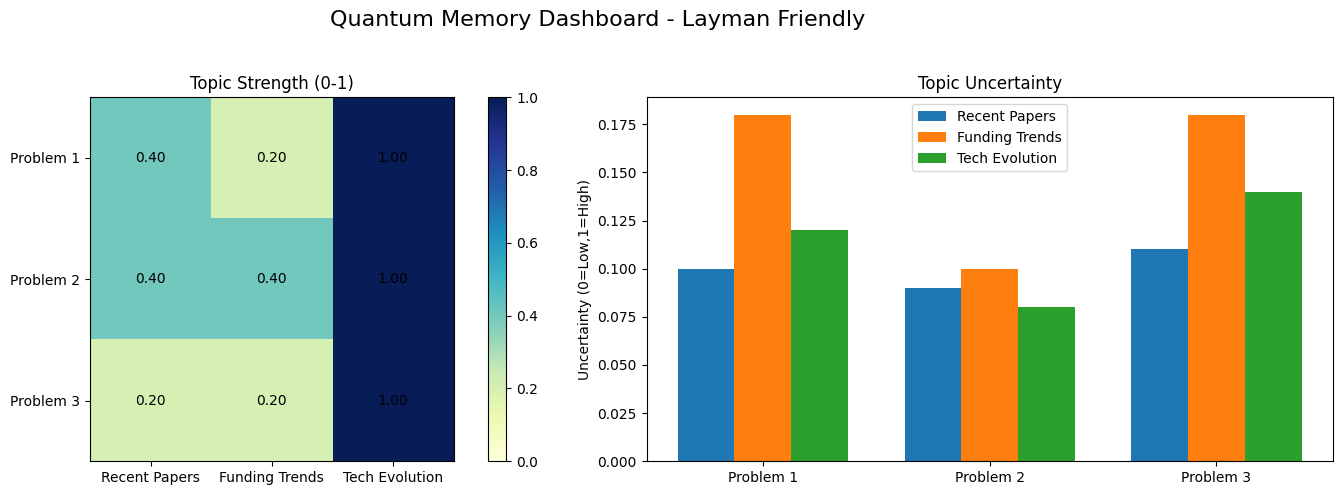

     Problem                                       Question  \
0  Problem 1    Recent trends in quantum computing hardware   
1  Problem 2                Funding patterns in AI startups   
2  Problem 3  Technological evolution in quantum algorithms   

            Sampled States  Topic Strength - Recent Papers  \
0  001, 001, 101, 001, 111                             0.4   
1  111, 001, 001, 111, 001                             0.4   
2  011, 001, 101, 001, 001                             0.2   

   Topic Strength - Funding Trends  Topic Strength - Tech Evolution  \
0                              0.2                              1.0   
1                              0.4                              1.0   
2                              0.2                              1.0   

   Uncertainty - Recent Papers  Uncertainty - Funding Trends  \
0                         0.10                          0.18   
1                         0.09                          0.10   
2                    

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
import requests
import re

num_qubits = 3
quantum_memory = None

# -----------------------------
def fetch_live_scores(question):
    """
    Fetch real arXiv papers and compute realistic topic scores.
    """
    url = "http://export.arxiv.org/api/query"
    params = {"search_query": "all:quantum computing", "start": 0, "max_results": 3}
    
    topics_keywords = {
        "Recent Papers": ["quantum", "qubit", "superconducting", "ion trap"],
        "Funding Trends": ["funding", "investment", "startup", "venture"],
        "Tech Evolution": ["algorithm", "optimization", "hardware", "circuit"]
    }
    
    scores = {}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        entries = response.text.split("<entry>")[1:]
        for topic, keywords in topics_keywords.items():
            count = 0
            for entry in entries:
                title = entry.split("<title>")[1].split("</title>")[0].lower()
                abstract_search = re.findall(r"<summary>(.*?)</summary>", entry, re.DOTALL)
                abstract = abstract_search[0].lower() if abstract_search else ""
                text = title + " " + abstract
                for kw in keywords:
                    count += text.count(kw)
            scores[topic] = min(count / 10, 1.0)
    except:
        scores = {
            "Recent Papers": np.random.uniform(0.5, 1.0),
            "Funding Trends": np.random.uniform(0.3, 0.9),
            "Tech Evolution": np.random.uniform(0.2, 0.8)
        }
    return scores

# -----------------------------
def quantum_memory_dashboard(problems, num_samples=5):
    global quantum_memory
    dashboard_data = []
    topic_activation_data = []

    for idx, question in enumerate(problems):
        # Fetch scores
        scores = fetch_live_scores(question)
        theta_inputs = [v * np.pi for v in scores.values()]
        qc = QuantumCircuit(num_qubits)
        for i, theta in enumerate(theta_inputs):
            qc.ry(theta, i)
        qc.cx(0,1)
        qc.cx(1,2)

        # Multi-cycle update
        new_psi = Statevector.from_instruction(qc)
        if quantum_memory is not None:
            new_psi = 0.5 * new_psi + 0.5 * quantum_memory
        quantum_memory = new_psi

        # Density matrix & sampling
        rho = DensityMatrix(quantum_memory)
        probs = np.abs(quantum_memory.data)**2
        probs = probs / np.sum(probs)
        states = [format(i,'03b') for i in range(2**num_qubits)]
        sampled_states = np.random.choice(states, size=num_samples, p=probs)

        # Per-qubit entropy -> uncertainty
        uncertainty = []
        for qubit in range(num_qubits):
            reduced_rho = partial_trace(rho, [i for i in range(num_qubits) if i != qubit])
            eigs = np.linalg.eigvals(reduced_rho.data)
            entropy = -np.sum([v*np.log2(v) for v in eigs if v > 0]).real
            uncertainty.append(entropy)

        # Convert sampled bit-strings to topic activation (0-1)
        activation = np.zeros(num_qubits)
        for state in sampled_states:
            for i, bit in enumerate(state):
                activation[i] += int(bit)
        activation = activation / num_samples
        topic_activation_data.append(activation)

        # Append table data
        dashboard_data.append({
            "Problem": f"Problem {idx+1}",
            "Question": question,
            "Sampled States": ", ".join(sampled_states),
            "Topic Strength - Recent Papers": round(activation[0],2),
            "Topic Strength - Funding Trends": round(activation[1],2),
            "Topic Strength - Tech Evolution": round(activation[2],2),
            "Uncertainty - Recent Papers": round(uncertainty[0],2),
            "Uncertainty - Funding Trends": round(uncertainty[1],2),
            "Uncertainty - Tech Evolution": round(uncertainty[2],2)
        })

    # -----------------------------
    # Create DataFrame
    df = pd.DataFrame(dashboard_data)

    # -----------------------------
    # Create combined dashboard figure
    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    # Left: Topic Strength Heatmap
    topic_activation_array = np.array(topic_activation_data)
    im1 = axes[0].imshow(topic_activation_array, cmap="YlGnBu", vmin=0, vmax=1)
    axes[0].set_xticks(np.arange(num_qubits))
    axes[0].set_yticks(np.arange(len(problems)))
    axes[0].set_xticklabels(["Recent Papers", "Funding Trends", "Tech Evolution"])
    axes[0].set_yticklabels([f"Problem {i+1}" for i in range(len(problems))])
    for i in range(len(problems)):
        for j in range(num_qubits):
            axes[0].text(j, i, f"{topic_activation_array[i,j]:.2f}",
                         ha="center", va="center", color="black")
    axes[0].set_title("Topic Strength (0-1)")
    fig.colorbar(im1, ax=axes[0])

    # Right: Uncertainty Bar Chart
    uncertainty_array = df[["Uncertainty - Recent Papers",
                            "Uncertainty - Funding Trends",
                            "Uncertainty - Tech Evolution"]].values
    x = np.arange(len(problems))
    width = 0.25
    axes[1].bar(x - width, uncertainty_array[:,0], width, label="Recent Papers")
    axes[1].bar(x, uncertainty_array[:,1], width, label="Funding Trends")
    axes[1].bar(x + width, uncertainty_array[:,2], width, label="Tech Evolution")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f"Problem {i+1}" for i in x])
    axes[1].set_ylabel("Uncertainty (0=Low,1=High)")
    axes[1].set_title("Topic Uncertainty")
    axes[1].legend()

    plt.suptitle("Quantum Memory Dashboard - Layman Friendly", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    return df

# -----------------------------
# Example usage:
problems = [
    "Recent trends in quantum computing hardware",
    "Funding patterns in AI startups",
    "Technological evolution in quantum algorithms"
]

dashboard_df = quantum_memory_dashboard(problems)
print(dashboard_df)
